In [1]:
import torch, torchvision, os, PIL, pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def show(tensor, num=25, wandbactive=0, name=''):
  data = tensor.detach().cpu()
  grid = make_grid(data[:num], nrow=5).permute(1, 2, 0)

  # optional: weights and biases
  if (wandbactive == 1 and wandbact == 1):
    wandbactive.log({name: wandbactive.image(grid.numpy.clip(0, 1))})

  plt.imshow(grid.clip(0, 1))
  plt.show()

In [3]:
# hyperparameters and general parameters
n_epochs = 10000
batch_size = 128
lr = 1e-4
z_dim = 200
device = 'cuda' # GPU

cur_step = 0
crit_cycles = 5 # we are going to have 5 cycles of critic per 1 cycle of generator.
gen_losses = []
crit_losses = []
show_step = 35
save_step = 35
wandbact = 1 # Yes, we want to track stats through weights and biases. optional.

In [4]:
# optional: to communicate with wandb
! pip install wandb -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 25.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00


In [5]:
import wandb
wandb.login(key='DELETED')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
%%capture
experiment_name = wandb.util.generate_id()

myrun = wandb.init(
    project='wgan',
    group=experiment_name,
    config={
        "optimizer":"adam",
        "model": "wgan gp",
        "epoch": "1000",
        "batch_size": "128"
    }
)

config = wandb.wandb.config

In [7]:
print(experiment_name)

qudmikbm


In [8]:
from torch.nn.modules.batchnorm import BatchNorm2d
# Generator model

class Generator(nn.Module):
  def __init__(self, z_dim= 64, d_dim=16):
    super(Generator, self).__init__()
    self.z_dim = z_dim

    self.gen = nn.Sequential(
        # ConvTranspose2d: in_channels, out_channels, kernel_size, stride=1, padding=0
        # Calculating new width and height: (n-1)*stride - 2*padding + ks
        # n = width or height
        # ks = kernel size
        # We begin with a 1x1 image with z_dim number of channels (200).
        nn.ConvTranspose2d(z_dim, d_dim*32, 4, 1, 0), # 4x4 (ch: from 200 to 512): (1-1)*2 - 2*0 + 4 = 4
        nn.BatchNorm2d(d_dim*32),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*32, d_dim*16, 4, 2, 1), # 8x8 (ch: from 512 to 256): (4-1)*2 - 2*1 + 4 = 8
        nn.BatchNorm2d(d_dim*16),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*16, d_dim*8, 4, 2, 1), # 16x16 (ch: from 256 to 128): (8-1)*2 - 2*1 + 4 = 16
        nn.BatchNorm2d(d_dim*8),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*8, d_dim*4, 4, 2, 1), # 32x32 (ch: from 128 to 64): (16-1)*2 - 2*1 + 4 = 32
        nn.BatchNorm2d(d_dim*4),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*4, d_dim*2, 4, 2, 1), # 64x64 (ch: from 64 to 32): (32-1)*2 - 2*1 + 4 = 64
        nn.BatchNorm2d(d_dim*2),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*2, 3, 4, 2, 1), # 128x128 (ch: from 32 to 3): (64-1)*2 - 2*1 + 4 = 128
        nn.Tanh() # Produce result in the range from -1 to 1
    )

  def forward(self, noise):
    x = noise.view(len(noise), self.z_dim, 1, 1) # 128 x 200 x 1 x 1
    return self.gen(x)

def gen_noise(number, z_dim, device='cuda'): # number: how many of them, z_dim: dimensionality of each
  return torch.randn(number, z_dim, device=device) # 128 x 200

In [9]:
class Critic(nn.Module):
  def __init__(self, d_dim=16):
    super(Critic, self).__init__()

    self.crit = nn.Sequential(
        # Conv2d: in_channels, out_channels, kernel_size, stride=1, padding=0
        # Calculating new width and height: (n + 2*padding - ks)//stride + 1
        nn.Conv2d(3, d_dim, 4, 2, 1), # 64x64 (ch: from 3 to 16): (128 + 2*1 - 4)//2 + 1 = 64
        nn.InstanceNorm2d(d_dim),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim, d_dim*2, 4, 2, 1), # 32x32 (ch: from 16 to 32): (64 + 2*1 - 4)//2 + 1 = 32
        nn.InstanceNorm2d(d_dim*2),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*2, d_dim*4, 4, 2, 1), # 16x16 (ch: from 32 to 64): (32 + 2*1 - 4)//2 + 1 = 16
        nn.InstanceNorm2d(d_dim*4),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*4, d_dim*8, 4, 2, 1), # 8x8 (ch: from 64 to 128): (16 + 2*1 - 4)//2 + 1 = 8
        nn.InstanceNorm2d(d_dim*8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*8, d_dim*16, 4, 2, 1), # 4x4 (ch: from 128 to 256): (8 + 2*1 - 4)//2 + 1 = 4
        nn.InstanceNorm2d(d_dim*16),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*16, 1, 4, 1, 0), # 1x1 (ch: from 256 to 1): (4 + 2*0 - 4)//1 + 1 = 1
    )

  def forward(self, image):
    # image: 128 x 3 x 128 x 128
    crit_pred = self.crit(image) # 128 x 1 x 1 x 1
    return crit_pred.view(len(crit_pred), -1) # 128 x 1

In [10]:
# optional: init your weights in different ways
def init_weights(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

In [11]:
# load dataset
import gdown, zipfile

# url = 'https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?usp=share_link&resourcekey=0-dYn9z10tMJOBAkviAcfdyQ'
path = 'data/celeba'
download_path = f'{path}/celeba_subset.zip'

if not os.path.exists(path):
  os.makedirs(path)

#gdown.download(url, download_path, quiet=False)

In [13]:
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(path)

In [14]:
class Dataset(Dataset):
  def __init__(self, path, size=128, lim=10000):
    self.sizes = [size, size]
    items, labels = [], []

    for data in os.listdir(path)[:lim]:
      # path: './data/celeba/celeba_subset'
      # data: '114568.jpg'
      item = os.path.join(path, data)
      items.append(item)
      labels.append(data) # we do not need labels
    self.items = items
    self.labels = labels

  def __len__(self):
    return len(self.items)

  def __getitem__(self, idx):
    data = PIL.Image.open(self.items[idx]).convert('RGB') # with whatever the size of the image is
    data = np.asarray(torchvision.transforms.Resize(self.sizes)(data)) # 128 x 128 x 3
    data = np.transpose(data, (2, 0, 1)).astype(np.float32, copy=False) # 3 x 128 x 128 ==> from 0 to 255
    data = torch.from_numpy(data).div(255) # from 0 to 1
    return data, self.labels[idx]

# Dataset
data_path = './data/celeba/celeba_subset'
ds = Dataset(data_path, size=128, lim=10000)

In [15]:
# Dataloader
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [16]:
# Models
gen = Generator(z_dim).to(device)
crit = Critic().to(device)

In [17]:
# optimizers
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.9))
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(0.5, 0.9))

In [ ]:
# Initialization
#gen = gen.apply(init_weights)
#crit = crit.apply(init_weights)

In [18]:
# wandb optional
if (wandbact == 1):
  wandb.watch(gen, log_freq=100)
  wandb.watch(crit, log_freq=100)

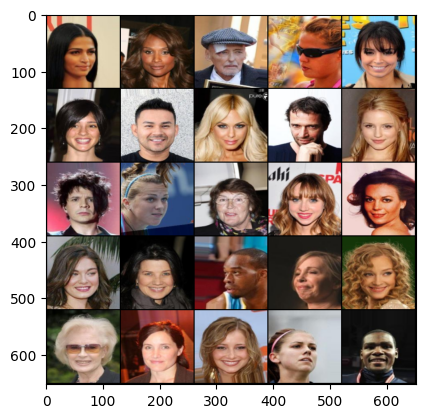

In [19]:
# testing
x, y = next(iter(dataloader))
show(x)

In [20]:
# gradient penalty calculation

def get_gp(real, fake, crit, alpha, gamma=10):
  mix_images = real * alpha + fake * (1 - alpha) # linear interpolation 128 x 3 x 128 x 128
  mix_scores = crit(mix_images) # 128 x 1

  gradient = torch.autograd.grad(
      inputs = mix_images,
      outputs = mix_scores,
      grad_outputs = torch.ones_like(mix_scores),
      retain_graph = True,
      create_graph = True
  )[0] # 128 x 3 x 128 x 128

  gradient = gradient.view(len(gradient), -1) # 128 x 49152
  gradient_norm = gradient.norm(2, dim=1) # type: 2 | dim=1 ==> 49152
  gp = gamma * ((gradient_norm-1)**2).mean()

  return gp

In [21]:
# save checkpoints

root_path = './data/'

def save_checkpoints(name):
  torch.save({
      'epoch': epoch,
      'model_state_dict': gen.state_dict(),
      'optimizer_state_dict': gen_opt.state_dict()
  }, f"{root_path}G-{name}.pkl")

  torch.save({
      'epoch': epoch,
      'model_state_dict': crit.state_dict(),
      'optimizer_state_dict': crit_opt.state_dict()
  }, f"{root_path}C-{name}.pkl")

  print("Saved checkpoint")

In [22]:
# load checkpoints

def load_checkpoint(name):
  checkpoint = torch.load(f"{root_path}G-{name}.pkl")
  gen.load_state_dict(checkpoint['model_state_dict'])
  gen_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  checkpoint = torch.load(f"{root_path}C-{name}.pkl")
  crit.load_state_dict(checkpoint['model_state_dict'])
  crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  print("Loaded checkpoint")

In [23]:
# training loop
# Each epoch: 10000 / 128 = 79 steps

for epoch in range(n_epochs):
  for real, _ in tqdm(dataloader):
    cur_bs = len(real) # 128
    real = real.to(device) # put them into the GPU

    # CRITIC
    mean_crit_loss = 0
    for _ in range(5): # for every iteration we train critic 5 times
      crit_opt.zero_grad()


      noise = gen_noise(cur_bs, z_dim)
      fake = gen(noise)
      crit_fake_pred = crit(fake.detach()) # we detach it because we do not want to optimize the generator's parameters
      crit_real_pred = crit(real)

      alpha = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True) # 128 x 1 x 1 x 1

      # with torch.autocast(device_type='cuda'):
      gp = get_gp(real, fake.detach(), crit, alpha)

      crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp

      mean_crit_loss += crit_loss / crit_cycles

      crit_loss.backward(retain_graph=True)
      crit_opt.step()

    crit_losses += [mean_crit_loss]

    # GENERATOR
    gen_opt.zero_grad()
    noise = gen_noise(cur_bs, z_dim)
    fake = gen(noise)
    crit_fake_pred = crit(fake)

    gen_loss = -crit_fake_pred.mean()
    gen_loss.backward()
    gen_opt.step()

    gen_losses += [gen_loss.item()]

    # Stats

    if (wandbact == 1):
      wandb.log({'Epoch': epoch, 'Step': cur_step, 'Critic loss': mean_crit_loss, 'Gen loss':gen_loss})

    if (cur_step % save_step == 0 and cur_step > 0):
      print("Saving checkpoint:", cur_step, save_step)
      save_checkpoints("latest")

    if (cur_step % show_step == 0 and cur_step > 0):
      show(fake, wandbactive=1, name='fake') # wandbactive=1 ==> we send data to wandb
      show(real, wandbactive=1, name='real')

      gen_mean = sum(gen_losses[-show_step:]) / show_step
      crit_mean = sum(crit_losses[-show_step:]) / show_step
      print(f"Epoch: {epoch}, step: {cur_step}, Generator loss: {gen_mean}, Critic loss: {crit_mean}")

      plt.plot(
          range(len(gen_losses)), # x axis
          torch.tensor(gen_losses), # y axis
          label="Generator Loss"
      )

      plt.plot(
          range(len(gen_losses)), # x axis (same for both gen and crit)
          torch.tensor(crit_losses), # y axis
          label="Critic Loss"
      )

      plt.ylim(-1000, 1000)
      plt.legend()
      plt.show()

    cur_step += 1

  0%|          | 0/79 [00:00<?, ?it/s]

OutOfMemoryError: ignored

In [ ]:
# Generate new faces
noise = gen_noise(batch_size, z_dim)
fake = gen(noise)
show(fake)

In [ ]:
plt.imshow(fake[4].detach().cpu().permute(1, 2, 0).squeeze().clip(0, 1))

In [2]:
from mpl_toolkits.axes_grid1 import ImageGrid

# Morphing. interpolation between points in latent space
gen_set = []
z_shape = [1, 200, 1, 1] # 200 is the size of the latent space
rows = 4
steps = 17

for i in range(rows):
  z1, z2 = torch.randn(z_shape), torch.randn(z_shape)
  for alpha in np.linspace(0, 1, steps):
    z = alpha*z1 + (1-alpha)*z2
    res = gen(z.cuda())[0]
    gen_set.append(res)

fig = plt.figure(figsize=(25, 11))
grid = ImageGrid(fig, 111, nrows_ncols=(rows, steps), axes_pad=0.1)

for ax, img in zip(grid, gen_set):
  ax.axis('off')
  res = img.cpu().detach().permute(1, 2, 0)
  # normalize res
  res = res - res.min()
  res = res/(res.max()-res.min())
  ax.imshow(res)

plt.show()